### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №3 - Дерево решений


**Общая информация**

**Срок сдачи:** 27 апреля 2020, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 27 апреля, -4 балла после 08:30 4 мая, -6 баллов после 08:30 11 мая, -8 баллов после 08:30 18 мая.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0220, Задание 3] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Реализуем дерево решений (3 балла)

Допишите недостающие части дерева решений. Ваша реализация дерева должна работать по точности не хуже DecisionTreeClassifier из sklearn.
Внимание: если Вас не устраивает предложенная структура хранения дерева, Вы без потери баллов можете сделать свой класс DecisionTreeClassifier, в котором сами полностью воспроизведете алгоритм дерева решений. Обязательно в нем иметь только функции fit, predict

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy

from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier

In [2]:
class MyDecisionTreeClassifier:
    NON_LEAF_TYPE = 0
    LEAF_TYPE = 1

    def __init__(self, min_samples_split=2, max_depth=5, criterion='gini'):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.num_class = -1
        # Для последнего задания
        self.feature_importances_ = None
        self.criterion = criterion
        self.tree = dict()
        self.used_features = []

    def __div_samples(self, x, y, feature_id, threshold):
        left_mask = x[:, feature_id] > threshold
        right_mask = ~left_mask
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]
    
    def __F(self, y):
        if len(y) == 0:
            return 1
        if (self.criterion == 'gini'):
            cnt = np.bincount(y)**2 / len(y)**2
            return 1 - np.sum(cnt)
                
        if (self.criterion == 'entropy'):
            cnt = np.bincount(y) / len(y)
            return -np.sum(cnt * np.log(np.where(np.isclose(cnt, 0), 1, cnt)))
        
        if (self.criterion == 'misclassification'):
            cnt = np.bincount(y) / len(y)
            return 1 - np.max(cnt)
            
        return imp

    def __find_threshold(self, x, y):
        feature, threshold, info_gain = 0, 0, -1
        for i in range(x.shape[1]):
            if i in self.used_features:
                continue
            for val in np.unique(x[:, i]):
                x_l, x_r, y_l, y_r = self.__div_samples(x, y, i, val)
                Q = self.__F(y) - (self.__F(y_l) * len(x_l) + self.__F(y_r) * len(x_r)) / len(x)
                if Q > info_gain:
                    info_gain, feature, threshold = Q, i, val
                    
        self.used_features.append(feature)
        self.feature_importances_[feature] += info_gain
        return feature, threshold

    def __fit_node(self, x, y, node_id, depth):
        if depth == self.max_depth or len(x) < self.min_samples_split or \
        len(np.unique(y)) == 1 or len(self.used_features) == len(x[0]):
            cnt = scipy.stats.mode(y)[0][0]
            self.tree[node_id] = [self.__class__.LEAF_TYPE,
                                int(cnt),
                                cnt / len(y)]
            return
        
        feature_id, threshold = self.__find_threshold(x, y)
        x_l, x_r, y_l, y_r = self.__div_samples(x, y, int(feature_id), threshold)
        
        self.tree[node_id] = [self.__class__.NON_LEAF_TYPE,
                            int(feature_id), threshold]
        
        self.__fit_node(x_l, y_l, 2 * node_id + 1, depth + 1)
        self.__fit_node(x_r, y_r, 2 * node_id + 2, depth + 1)
    
    def fit(self, x, y):
        self.num_class = np.unique(y)
        self.feature_importances_ = np.zeros(len(x[0]))
        self.__fit_node(x, y, 0, 0) 

    def __predict_class(self, x, node_id):
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[feature_id] > threshold:
                return self.__predict_class(x, 2 * node_id + 1)
            else:
                return self.__predict_class(x, 2 * node_id + 2)
        else:
            return node[1]
        
    def predict(self, X):
        return np.array([self.__predict_class(x, 0) for x in X])
    
    def fit_predict(self, x_train, y_train, predicted_x):
        self.fit(x_train, y_train)
        return self.predict(predicted_x)
    
    def get_feature_importance(self):
        return self.feature_importances_

In [3]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2, criterion='gini')
clf = DecisionTreeClassifier(min_samples_split=2, criterion='gini')

In [4]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)
my_clf.fit(X_train, y_train)
clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [5]:
accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

0.8888888888888888

In [6]:
accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)

0.9444444444444444

## Ускоряем дерево решений (2 балла)
Добиться скорости работы на fit не медленнее чем в 10 раз sklearn на данных wine. 
Для этого используем numpy.

In [9]:
%time my_clf.fit(X_train, y_train)

CPU times: user 344 µs, sys: 95 µs, total: 439 µs
Wall time: 354 µs


In [10]:
%time clf.fit(X_train, y_train)

CPU times: user 1.35 ms, sys: 681 µs, total: 2.03 ms
Wall time: 1.32 ms


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

## Боевое применение (3 балла)

На практике Вы познакомились с датасетом Speed Dating Data. В нем каждая пара в быстрых свиданиях характеризуется определенным набором признаков. Задача -- предсказать, произойдет ли матч пары (колонка match). 

Пример работы с датасетом можете найти в практике пункт 2
https://github.com/VVVikulin/ml1.sphere/blob/master/2019-09/lecture_06/pract-trees.ipynb

Данные и описания колонок лежат тут
https://cloud.mail.ru/public/8nHV/p6J7wY1y1/speed-dating-experiment/

Скачайте датасет, обработайте данные, как показано на семинаре или своим собственным способом. Обучите дерево классифкации. В качестве таргета возьмите колонку 'match'. Постарайтесь хорошо обработать признаки, чтобы выбить максимальную точность. Если точность будет близка к случайному гаданию, задание не будет защитано. 


In [20]:
df = pd.read_csv('Speed Dating Data.csv', encoding='latin1')
df = df.iloc[:, :97]

def code_feature(df, feature):
    for i in df[feature].unique():
        df[feature + '=' + str(i)] = (df[feature] == i).astype(float)
    return df

In [21]:
df = df.drop(['id', 'idg', 'round', 'position', 'positin1', 'order', 
              'age_o', 'race_o', 'pf_o_att', 
              'pf_o_sin', 'pf_o_int',
              'pf_o_fun', 'pf_o_amb', 'pf_o_sha',
              'dec_o', 'attr_o', 'sinc_o', 'intel_o', 'fun_o',
              'amb_o', 'shar_o', 'like_o', 'prob_o','met_o',
              'undergra', 'mn_sat', 'tuition', 'partner',
              'from', 'zipcode', 'condtn', 'income', 'expnum'], 
             axis=1)
df = df.drop(['sports','tvsports','exercise','dining','museums','art',
              'hiking','gaming', 'clubbing','reading','tv','theater',
              'movies','concerts','music','shopping','yoga'],
             axis=1)

df = df.dropna(subset=['age'])
df = df.dropna(subset=['imprelig', 'imprace'])

# for i, group in df.groupby('field_cd'):
#     print('=' * 10)
#     print('Field Code {}'.format(i))
#     print(group.field.unique())
    
df.loc[:, 'field_cd'] = df.loc[:, 'field_cd'].fillna(19)
df = code_feature(df, 'field_cd')
df = df.drop(['field'], axis=1)

# Black/African American=1
# European/Caucasian-American=2
# Latino/Hispanic American=3
# Asian/Pacific Islander/Asian-American=4
# Native American=5
# Other=6

df.loc[:, 'race'] = df.loc[:, 'race'].fillna(6)  
df = code_feature(df, 'race')
df = df.drop(['race'], axis=1)

# for i, group in df.groupby('career_c'):
#     print('=' * 10)
#     print('career_c {}'.format(i))
#     print(group.career.unique())
    
df.loc[:, 'career_c'] = df.loc[:, 'career_c'].fillna(18)
df = code_feature(df, 'career_c')
df = df.drop(['career'], axis=1)

df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']].sum(axis=1)
df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']] = \
(df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']].T / df.loc[:, 'temp_totalsum'].T).T * 100

df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']] = \
(df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']].T / df.loc[:, 'temp_totalsum'].T).T * 100

df = df.drop(['temp_totalsum'], axis=1)

for i in [4, 5]:
    feat = ['attr{}_1'.format(i), 'sinc{}_1'.format(i), 
            'intel{}_1'.format(i), 'fun{}_1'.format(i), 
            'amb{}_1'.format(i), 'shar{}_1'.format(i)]
    if i != 4:
        feat.remove('shar{}_1'.format(i))
    df = df.drop(feat, axis=1)

In [22]:
df = df.drop(['wave'], axis=1)
df_male = df.query('gender == 1').drop_duplicates(subset=['iid', 'pid'])\
                                 .drop(['gender'], axis=1)\
                                 .dropna()
df_female = df.query('gender == 0').drop_duplicates(subset=['iid'])\
                                   .drop(['gender', 'match', 'int_corr', 'samerace'], axis=1)\
                                   .dropna()
        
df_female.columns = df_female.columns + '_f'
df = df_male.set_index('iid').join(df_female.set_index('pid_f'))
df = df.drop(['iid_f', 'pid'], axis=1)

Разбейте датасет на трейн и валидацию. Подберите на валидации оптимальный критерий  информативности. 
Постройте графики зависимости точности на валидации от глубины дерева, от минимального числа объектов для сплита. 
Какой максимальной точности удалось достигнуть?

In [14]:
X = np.array(df.drop(['match'], axis=1))
y = np.array(df.loc[:, 'match'])
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.05, test_size=0.01)
print(X_train.shape)
print(y_train.shape)

(390, 140)
(390,)


In [15]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2, max_depth=5, criterion='entropy')
my_clf.fit(X_train, y_train)
accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)

0.9367088607594937

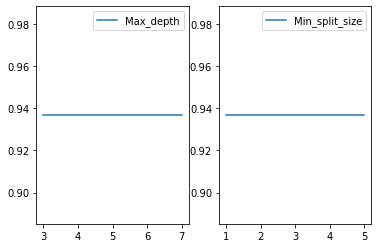

In [17]:
depths = np.arange(3, 8)
fig, ax = plt.subplots(1, 2)
acc = []

for d in depths:
    my_clf = MyDecisionTreeClassifier(min_samples_split=2, max_depth=d, criterion='entropy')
    my_clf.fit(X_train, y_train)
    acc.append(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))
    
ax[0].plot(np.arange(3, 8), acc, label=r'Max_depth')
ax[0].legend(loc='upper right')

splits = np.arange(1, 6)
acc = []
for s in splits:
    my_clf = MyDecisionTreeClassifier(min_samples_split=s, max_depth=5, criterion='entropy')
    my_clf.fit(X_train, y_train)
    acc.append(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))
    
ax[1].plot(np.arange(1, 6), acc, label=r'Min_split_size') 
ax[1].legend(loc='upper right')

plt.show()

# Они плоские (а почему)

## Находим самые важные признаки (2 балла)



По построенному дереву  легко понять, какие признаки лучше всего помогли решить задачу. Часто это бывает нужно  не только  для сокращения размерности в данных, но и для лучшего понимания прикладной задачи. Например, Вы хотите понять, какие признаки стоит еще конструировать -- для этого нужно понимать, какие из текущих лучше всего работают в дереве. 

Самый простой метод -- посчитать число сплитов, где использовался данные признак. Это не лучший вариант, так как по признаку который принимает всего 2 значения, но который почти точно разделяет выборку, число сплитов будет очень 1, но при этом признак сам очень хороший. 
В этом задании предлагается для каждого признака считать суммарный gain (в лекции обозначено как Q) при использовании этого признака в сплите. Тогда даже у очень хороших признаков с маленьким число сплитов это значение должно быть довольно высоким.  

Реализовать это довольно просто: создаете словарь номер фичи : суммарный гейн и добавляете в нужную фичу каждый раз, когда используете ее при построении дерева. 

Добавьте функционал, который определяет значения feature importance. Обучите дерево на датасете Speed Dating Data.
Выведите 10 главных фичей по важности.

In [23]:
X = np.array(df.drop(['match'], axis=1))
y = np.array(df.loc[:, 'match'])
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.1, test_size=0.01)

my_clf = MyDecisionTreeClassifier(min_samples_split=s, max_depth=5, criterion='entropy')
my_clf.fit(X_train, y_train)

best = np.argpartition(my_clf.get_feature_importance(), -10)[-10:]
print(np.array(df.columns.values.tolist())[best])

['sinc3_1' 'shar2_1' 'career_c' 'sinc2_1' 'int_corr' 'imprace' 'intel1_1'
 'career_c=16.0' 'samerace' 'amb1_1']


## Фидбек (бесценно)

* Какие аспекты обучения деревьев решений Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ



In [84]:
# Все замечательно, но почему графики плоские